# 내차팔기 홈 기본랜딩 AB test 분석

을 sample 로 노트북파일에서 sql 및 통계검정 한꺼번에 진행

process
1. 실험 결과 지표 추출
2. Metric에 대한 통계 검정

## 1. 실험결과 지표 추출

In [2]:
# ✅ ipynb template !!!✅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from IPython.display import display, Markdown

# pandas 출력 설정
pd.set_option('display.max_columns', None)      # 모든 열을 출력
pd.set_option('display.width', 2000)            # 한 줄에 최대 출력 길이 설정 (충분히 크게)
pd.set_option('display.max_colwidth', None)     # 각 열의 최대 출력 길이 제한 해제

# ✅ 전체 float 출력 포맷 소수점 4자리로 고정 (현재 세션에만 적용. python 다시 시작하면 다시 설정해줘야 함.)
pd.set_option('display.float_format', '{:.4f}'.format)

# ❄️ snowflake 설정 1
from sqlalchemy import create_engine
user = 'namgonlee_svc'
account = 'MAESGVY-TY96489'
private_key_file = '/Users/encr25n10048/Documents/namgonlee_svc_key.p8'
warehouse = 'USER_XSMALL'       # 필요 시 수정
# database = 'ENCAR'            # 필요 시 수정
# schema = 'LOGS_MART'          # 필요 시 수정
# role = 'USER_XSMALL'          # 필요 시 수정

# ❄️ snowflake 설정 2
# 🔐 private key 로드 및 변환
from cryptography.hazmat.primitives import serialization
with open(private_key_file, "rb") as key_file:
    p_key = serialization.load_pem_private_key(
        key_file.read(),
        password=None,
    )
pkb = p_key.private_bytes(
    encoding=serialization.Encoding.DER,
    format=serialization.PrivateFormat.PKCS8,
    encryption_algorithm=serialization.NoEncryption()
)

# ❄️ snowflake 설정 3
# SQLAlchemy 엔진 생성
engine = create_engine(
    f'snowflake://{user}@{account}?warehouse={warehouse}&',
    connect_args={
        'private_key': pkb,
    }
)

# dataframe output 에 대해 복사
# df.to_clipboard(index=False, sep='\t')

AB test 결과 분석 쿼리 (platform 에 따라 서로다른 컬럼에 들어오는 것을 통합하여 처리 하는 쿼리)

Mobile : ABTEST 컬럼

App : TESTTYPE 컬럼

MW 내차팔기 홈 디폴트 랜딩 AB test 

AB test 실험 참여된 시점 이후부터 모든 이벤트에 해당 컬럼으로 덮어 씌운 뒤 진행 -> 이유는 특정 페이지에서만 AB test 컬럼이 들어온다고 함. 그래서 정작 봐야하는 이벤트에 AB test 컬럼이 없기 때문에 이렇게 후처리로 진행.

이 쿼리로 할 경우 원래 데이터(ver.1) 보다 -0.5% 정도 의 모수 차이가 남.

In [ ]:
# sql 문 안에 변수처리하면 작동하지 않기 때문에 아래와 python 에서 변수처리 한 뒤 sql에는 파이썬 변수를 넣어야 한다.
# 변수list
# 변수 사용시 -> '{변수명}'               

abtestId = 'ab_685cd44042161e1e5fb4245c'
start_date = '2025-06-30'
end_date = '2025-07-07'


# SQL 실행 및 결과 불러오기
query = f'''
WITH 

log_base AS (

    SELECT
        BASE_DATE,
        EVENTTIME,
        PCID,
        ABTEST,
        TESTTYPE,
        SCREENNAME,
        EVENTTYPE,
        EVENTNAME,
        EVENTNAMEGROUP,
        BOARD,
        STATUS,
        OS_TYPE,
        OS_DETAIL,
        NULLIF(TRIM(f.value::STRING), '') AS ABTEST_SPLIT,
        SPLIT_PART(ABTEST_SPLIT, '_', 1) || '_' || SPLIT_PART(ABTEST_SPLIT, '_', 2) AS ABTEST_ID,
        SPLIT_PART(ABTEST_SPLIT, '_', 3) AS ABTEST_GROUP,
    FROM
        ENCAR.LOGS.ENLOG_ENCAR AS t1,
        LATERAL FLATTEN(input => SPLIT(t1.ABTEST, ',')) AS f
    WHERE
        1=1
        AND BASE_DATE BETWEEN '{start_date}' AND '{end_date}'
        AND OS_TYPE = 'mw'
        -- AND NOT (ess.OS_TYPE = 'app' AND ess.OS_DETAIL = 'ios')
),

mw_test_join_dt AS (        -- PCID 별 ABTEST 실험 최초참여시간 GROUP (Mobile web)

    SELECT
        PCID,
        EVENTTIME AS TEST_JOIN_DT,
        ABTEST_ID,
        ABTEST_GROUP,
    FROM
        log_base
    WHERE
        1=1
        AND ABTEST_ID = '{abtestId}'
        AND OS_TYPE IN ('mw', 'pc')
    QUALIFY ROW_NUMBER() OVER (PARTITION BY PCID ORDER BY EVENTTIME) = 1        -- 최초 실험 참여시점의 행만 가져오는 로직
),

app_test_join_dt AS (         -- PCID 별 ABTEST 실험 최초참여시간 GROUP (App)

    SELECT
        PCID,
        EVENTTIME AS TEST_JOIN_DT,
        '{abtestId}' AS ABTEST_ID,
        TESTTYPE AS ABTEST_GROUP,
    FROM
        log_base
    WHERE
        1=1
        AND OS_TYPE = 'app'
        AND TESTTYPE IS NOT NULL
        AND TESTTYPE != ''
    QUALIFY ROW_NUMBER() OVER (PARTITION BY PCID ORDER BY EVENTTIME) = 1                -- 최초 실험 참여시점의 행만 가져오는 로직
),

totl_test_join_dt AS (
    SELECT * FROM mw_test_join_dt
    UNION ALL
    SELECT * FROM app_test_join_dt
),

prep AS (
    SELECT
        t1.PCID,
        t1.BASE_DATE,
        t1.SCREENNAME,
        t1.EVENTTYPE,
        t1.EVENTNAME,
        t1.EVENTNAMEGROUP,
        t1.BOARD,
        t1.STATUS,
        t1.OS_TYPE,
        t1.OS_DETAIL,
        t2.ABTEST_ID,
        t2.ABTEST_GROUP,
    FROM
        log_base AS t1
        LEFT JOIN totl_test_join_dt AS t2 ON t1.PCID = t2.PCID AND t1.EVENTTIME >= t2.TEST_JOIN_DT
    WHERE
        1=1
        AND t2.ABTEST_ID IS NOT NULL
)

SELECT
    ABTEST_ID,
    MIN(BASE_DATE) AS START_DATE,
    MAX(BASE_DATE) AS END_DATE,
    OS_TYPE,
    ABTEST_GROUP,
    -- OS_DETAIL,
    -- BASE_DATE,
    
    COUNT(DISTINCT PCID) AS TOTAL_PCID,
    COUNT(PCID) AS TOTAL_EVENT,

    -- 내차팔기 영역
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME = '엔카홈' AND BOARD ='내차팔기' THEN PCID END) AS SELL_HOME,       -- 내차팔기 퍼널 1 - 번호판 조회
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME = '비교견적신청_소유자확인' THEN PCID END) AS CHECK_OWNER,              -- 내차팔기 퍼널 2- 소유자 확인
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME = '비교견적신청_정보확인중' THEN PCID END) AS TRY_MYGARAGE,              -- 내차팔기 퍼널 3- 내차고 등록 시도
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME = '엔카홈' AND BOARD = '내차고' AND STATUS = '정보입력중' THEN PCID END) AS MYCAR_HOME_ING,
    -- -- 비교견적 신청 완료 이벤트
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME IN ('비교견적신청_신청완료', '비교견적신청_프로신청완료', '비교견적플러스신청_신청완료') THEN PCID END) AS ESTIMATE_COMPLETE,


    -- 내차사기 영역
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME = '엔카홈' AND BOARD ='내차사기' THEN PCID END) AS BUY_HOME,
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME = '검색'                      THEN PCID END) AS SEARCH_HOME,
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'VIEW' AND SCREENNAME = '차량상세'                   THEN PCID END) AS CAR_DETAIL,
    COUNT(DISTINCT CASE WHEN EVENTTYPE = 'CLICK' AND SCREENNAME = '차량상세' AND EVENTNAME  IN ('문의하기', '엔카를통해구매하기') THEN PCID END) AS CAR_DETAIL_CONTACT,
    
FROM
    prep
WHERE
    1=1
    -- AND ABTEST_ID1 = '{abtestId}'
GROUP BY
    ALL
ORDER BY
    ABTEST_GROUP
'''
df = pd.read_sql(query, engine)

# 결과 확인
df

In [ ]:
display(Markdown('# 📊 AB test 결과'))
display(df)

# 📊 AB test 결과

,abtest_id,start_date,end_date,os_type,abtest_group,total_pcid,total_event,sell_home,check_owner,try_mygarage,mycar_home_ing,estimate_complete,buy_home,search_home,car_detail,car_detail_contact
0,ab_685cd44042161e1e5fb4245c,2025-06-30,2025-07-07,mw,A,385312,277322522,32007,8339,7152,6582,631,309623,336439,283457,6711
1,ab_685cd44042161e1e5fb4245c,2025-06-30,2025-07-07,mw,B,42586,30418540,40703,2240,1711,1535,71,32054,35679,30606,725


## 2. 통계 검정

In [ ]:
def abtest_auto(groups, successes, trials, metric_name="Metric", samples=100_000):
    failures = trials - successes
    conversion_rates = successes / trials

    print("\n" + "#"*70)
    print(f"📊 {metric_name}\n" + "#"*70)

    group_summary = pd.DataFrame({
        'Group': groups,
        'Successes': successes,
        'Trials': trials,
        'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
    })
    print("\n✅ Group Summary (Successes, Trials, Conversion Rate)")
    display(group_summary)
    print(f"\n{'='*60}")

    if len(groups) == 2:
        # ✅ Z-test (2개 그룹)
        count = np.array([successes[0], successes[1]])
        nobs = np.array([trials[0], trials[1]])
        zstat, pval = proportions_ztest(count, nobs)
        print("\n✅ Z-test (2 groups)")
        print(f"- Z statistic: {zstat:.4f}")
        print(f"- p-value: {pval:.4f}")
        print(f"\n{'='*60}")

        # ✅ Chi-square test (2x2 contingency table)
        contingency = np.array([
            [successes[0], failures[0]],
            [successes[1], failures[1]]
        ])
        chi2, chi_p, _, _ = chi2_contingency(contingency)
        print("\n✅ Chi-square Test (2x2)")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {chi_p:.4f}")
        print(f"\n{'='*60}")

    else:
        # ✅ Chi-square test (3개 이상)
        contingency_table = np.array([successes, failures]).T
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        print("\n✅ Chi-square Test")
        print(f"- Chi2 statistic: {chi2:.4f}")
        print(f"- p-value: {p_value:.4f}")
        print(f"\n{'='*60}")

        # ✅ 사후 Pairwise Z-test (Holm-Bonferroni 보정, 빈도주의 보수적 방식)
        pairwise_results, pairs = [], []
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                count = np.array([successes[i], successes[j]])
                nobs = np.array([trials[i], trials[j]])
                _, p = proportions_ztest(count, nobs)
                pairwise_results.append(p)
                pairs.append(f"{groups[i]} vs {groups[j]}")

        reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')
        results_df = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (Holm)': pvals_corrected,
            'Significant': reject
        })
        print("\n✅ Pairwise Z-test (Holm-Bonferroni):")
        display(results_df)
        print(f"\n{'='*60}")


        # ✅ 사후 Pairwise Z-test (FDR 보정, 빈도주의 유연한 방식)
        reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='fdr_bh')
        results_df_fdr = pd.DataFrame({
            'Comparison': pairs,
            'Uncorrected p-value': pairwise_results,
            'Corrected p-value (FDR)': pvals_fdr_corrected,
            'Significant (FDR)': reject_fdr
        })
        print("\n✅ Pairwise Z-test (FDR - Benjamini-Hochberg):")
        display(results_df_fdr)
        print(f"\n{'='*60}")

    # ✅ Bayesian analysis (공통)
    posterior_samples = {
        group: np.random.beta(1 + success, 1 + fail, samples)
        for group, success, fail in zip(groups, successes, failures)
    }

    plt.figure(figsize=(12, 7))
    for group in groups:
        sns.kdeplot(posterior_samples[group], label=f'Group {group}')
    plt.title('Posterior Distributions of Conversion Rates', fontsize=16)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\n{'='*60}")

    # ✅ 각 그룹이 best일 확률
    best_group_count = {group: 0 for group in groups}
    for i in range(samples):
        best_group = max(posterior_samples, key=lambda g: posterior_samples[g][i])
        best_group_count[best_group] += 1

    print("\n✅ Bayesian: Probability that each group is best")
    for group, count in best_group_count.items():
        prob = count / samples
        print(f"Probability that {group} is the best: {prob:.2%}")
    print(f"\n{'='*60}")

    # ✅ 쌍별 우위 확률
    pairwise_bayes = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
            pairwise_bayes.append({
                'Comparison': f"{g1} > {g2}",
                'P(Group1 > Group2)': prob,
                'P(Group1 < Group2)': 1 - prob
            })
    df_bayes = pd.DataFrame(pairwise_bayes)
    print("\n✅ Bayesian Pairwise Superiority Probabilities:")
    display(df_bayes)
    print(f"\n{'='*60}")



# ✅ 아래와 같이 세팅하여 사용하면 됨 ✅
# groups = ['A', 'B']
# groups = ['A', 'B', 'C']
# TOTAL_PCID = np.array([385312, 42586])
# SELL_HOME = np.array([32007, 40703])
# abtest_auto(groups, SELL_HOME, TOTAL_PCID, metric_name="Total PCID to Sell Home CVR")


# 이제 for 문과 df 에서 직접 지표 끌어와서 통계검정 하는 작업 진행

In [ ]:
# 여기서 이거 작업중임... 

# Test group 작성
groups = ['A', 'B']

# 실험 데이터
TOTAL_PCID = np.array([385312, 42586])
SELL_HOME = np.array([32007, 40703])
CHECK_OWNER = np.array([8339, 2240])
TRY_MYGARAGE = np.array([7152, 1711])
MYCAR_HOME_ING = np.array([6582, 1535])
ESTIMATE_COMPLETE = np.array([631, 71])
BUY_HOME = np.array([309623, 32054])
SEARCH_HOME = np.array([336439, 35679])
CAR_DETAIL = np.array([283457, 30606])
CAR_DETAIL_CONTACT = np.array([6711, 725])

# 지표 사전
metrics = {
    "Total PCID to Sell Home CVR": SELL_HOME,
    "Total PCID to Check Owner CVR": CHECK_OWNER,
    "Total PCID to Try MyGarage CVR": TRY_MYGARAGE,
    "Total PCID to MyCar Home CVR": MYCAR_HOME_ING,
    "Total PCID to Estimate Complete CVR": ESTIMATE_COMPLETE,
    "Total PCID to Buy Home CVR": BUY_HOME,
    "Total PCID to Search Home CVR": SEARCH_HOME,
    "Total PCID to Car Detail CVR": CAR_DETAIL,
    "Total PCID to Contact Click CVR": CAR_DETAIL_CONTACT,
}

metrics.items()

NameError: name 'np' is not defined


######################################################################
📊 Total PCID to Sell Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,32007,385312,8.31%
1,B,40703,42586,95.58%




✅ Z-test (2 groups)
- Z statistic: -455.0472
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 207061.7857
- p-value: 0.0000



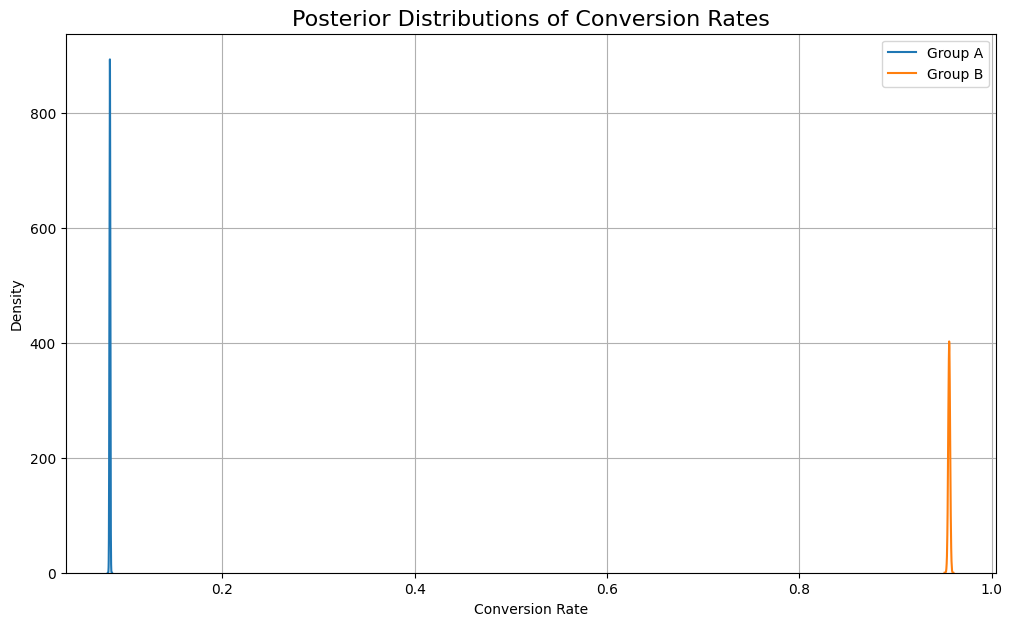



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Check Owner CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,8339,385312,2.16%
1,B,2240,42586,5.26%




✅ Z-test (2 groups)
- Z statistic: -39.0405
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 1522.8795
- p-value: 0.0000



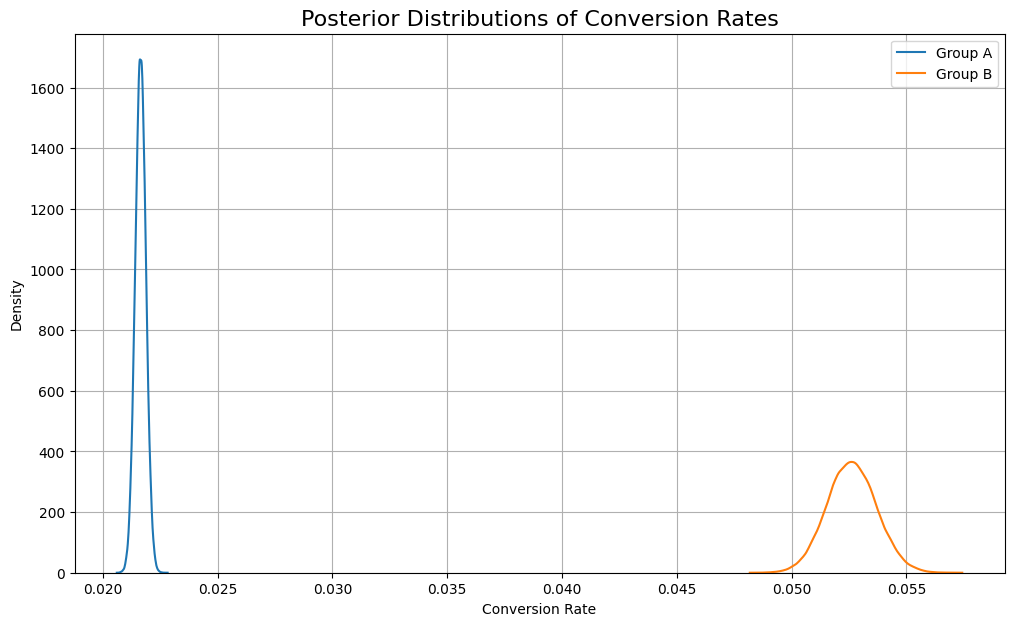



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Try MyGarage CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,7152,385312,1.86%
1,B,1711,42586,4.02%




✅ Z-test (2 groups)
- Z statistic: -29.7213
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 882.2930
- p-value: 0.0000



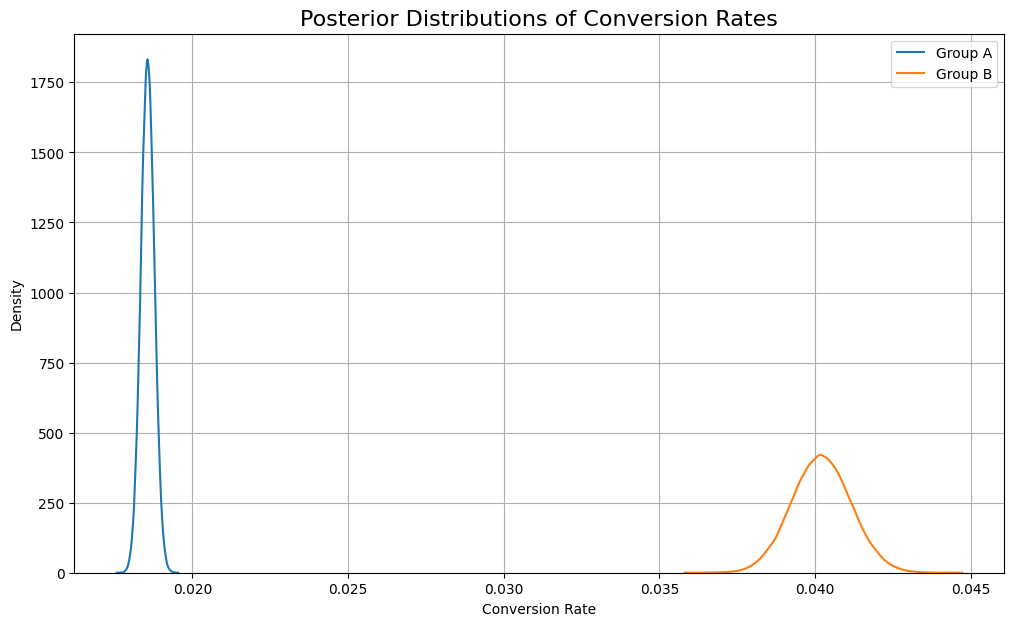



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to MyCar Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6582,385312,1.71%
1,B,1535,42586,3.60%




✅ Z-test (2 groups)
- Z statistic: -27.2204
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 739.9335
- p-value: 0.0000



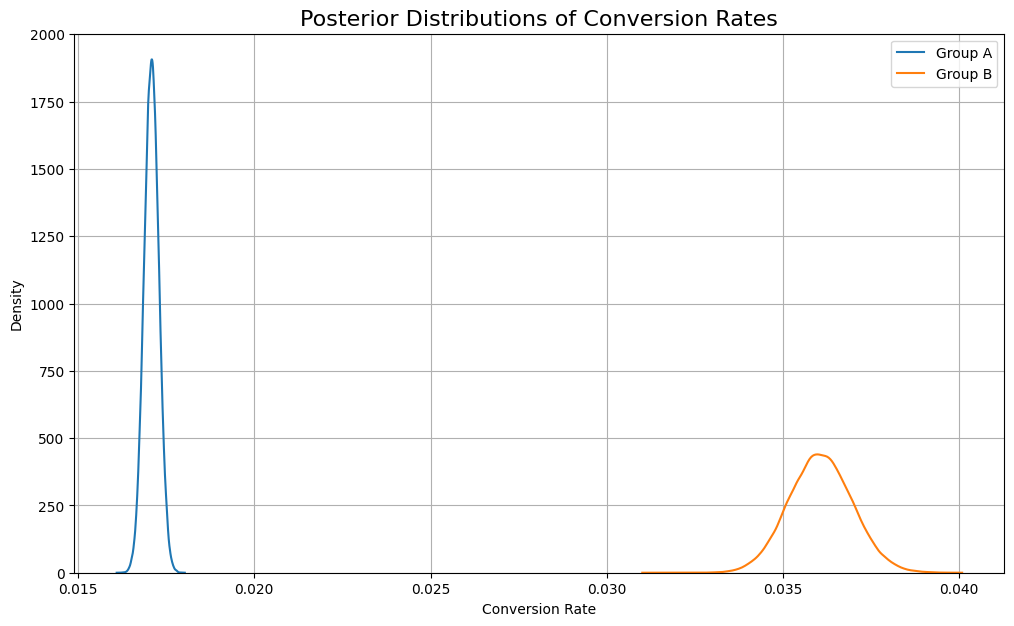



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Estimate Complete CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,631,385312,0.16%
1,B,71,42586,0.17%




✅ Z-test (2 groups)
- Z statistic: -0.1431
- p-value: 0.8862


✅ Chi-square Test (2x2)
- Chi2 statistic: 0.0064
- p-value: 0.9362



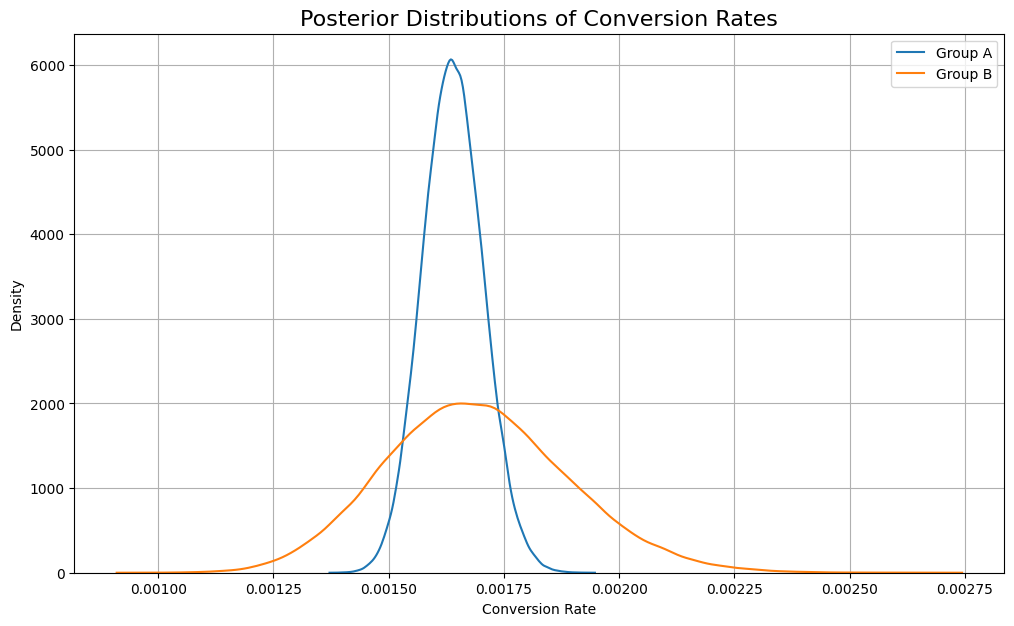



✅ Bayesian: Probability that each group is best
Probability that A is the best: 41.67%
Probability that B is the best: 58.33%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.4167,0.5833




######################################################################
📊 Total PCID to Buy Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,309623,385312,80.36%
1,B,32054,42586,75.27%




✅ Z-test (2 groups)
- Z statistic: 24.8374
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 616.5796
- p-value: 0.0000



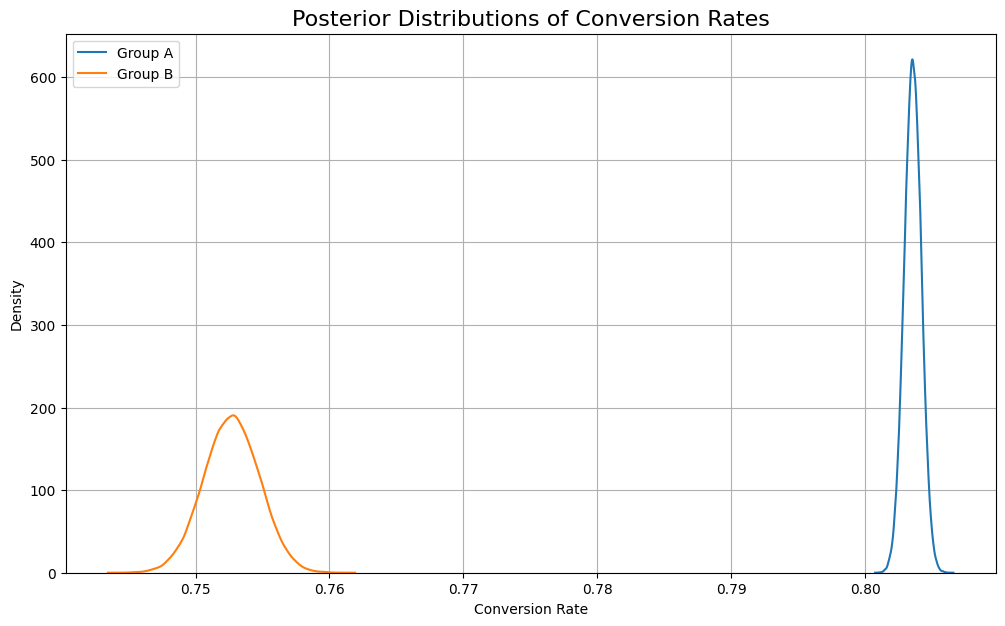



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Search Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,336439,385312,87.32%
1,B,35679,42586,83.78%




✅ Z-test (2 groups)
- Z statistic: 20.5595
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 422.3804
- p-value: 0.0000



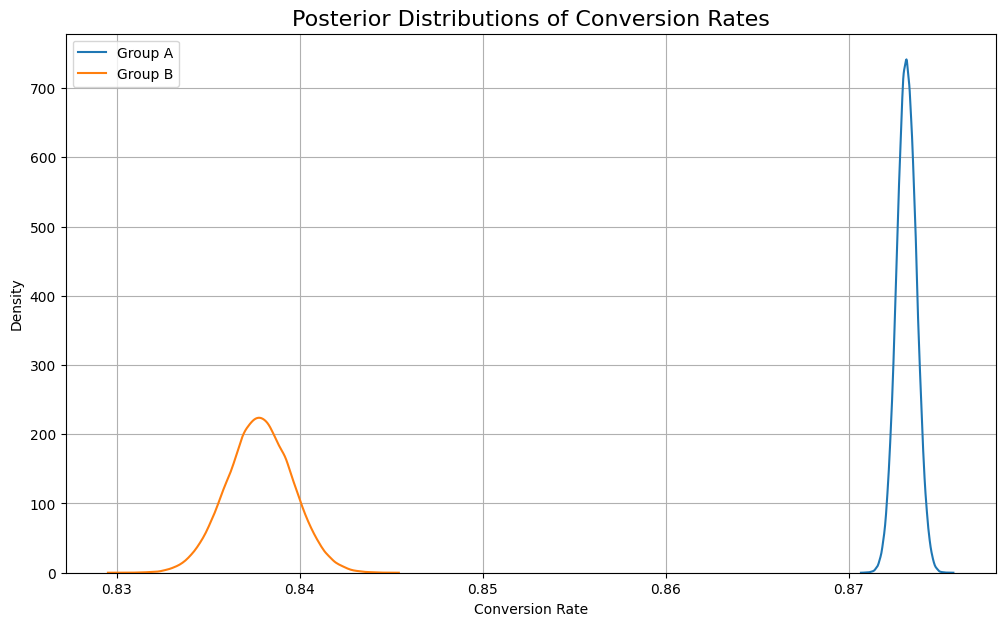



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Car Detail CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,283457,385312,73.57%
1,B,30606,42586,71.87%




✅ Z-test (2 groups)
- Z statistic: 7.5200
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 56.4633
- p-value: 0.0000



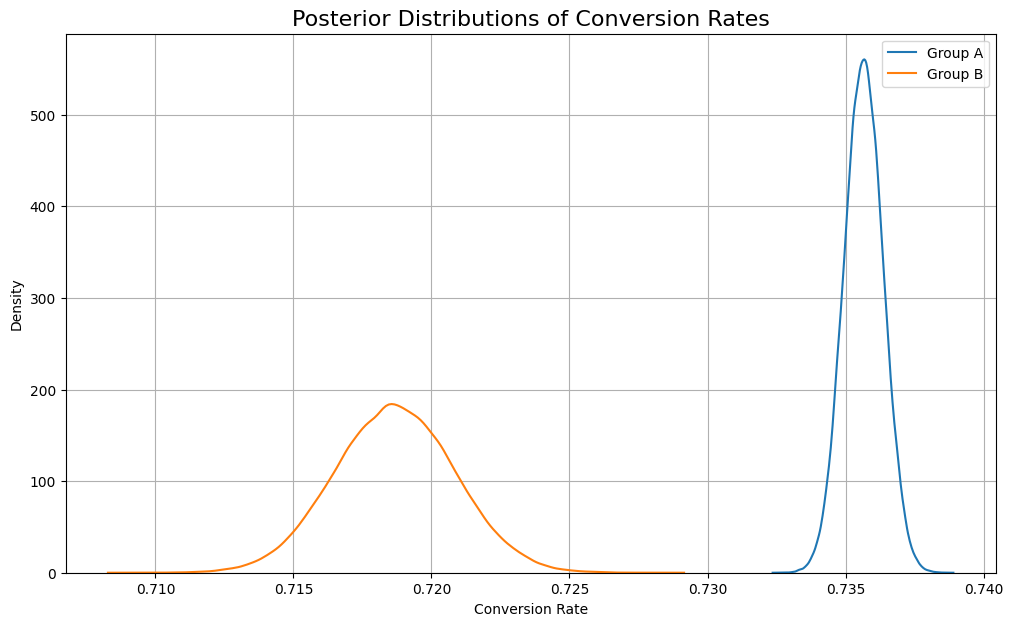



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Contact Click CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6711,385312,1.74%
1,B,725,42586,1.70%




✅ Z-test (2 groups)
- Z statistic: 0.5885
- p-value: 0.5562


✅ Chi-square Test (2x2)
- Chi2 statistic: 0.3237
- p-value: 0.5694



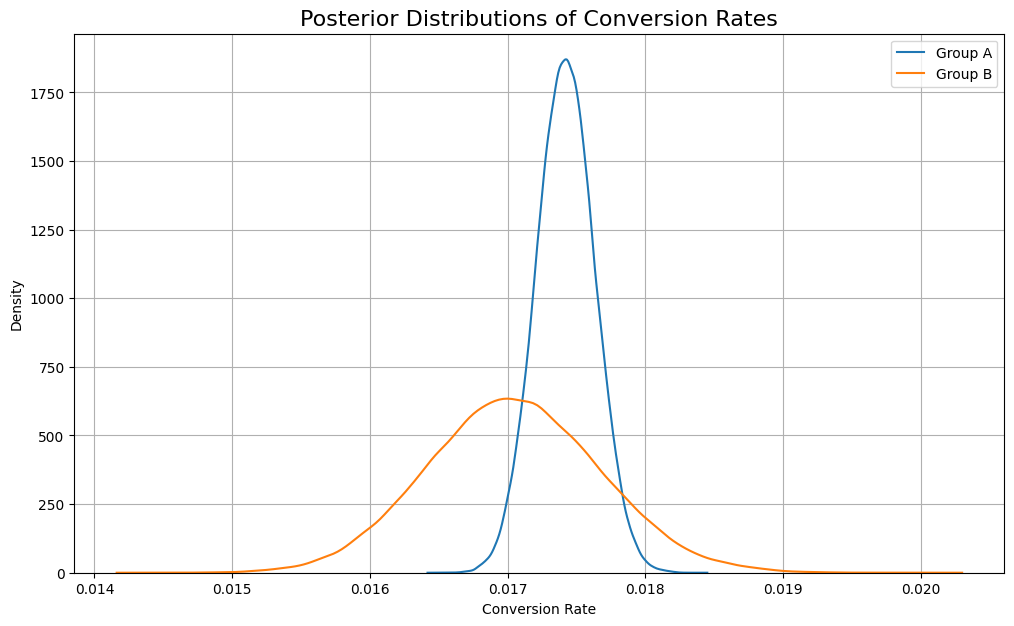



✅ Bayesian: Probability that each group is best
Probability that A is the best: 71.69%
Probability that B is the best: 28.31%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.7169,0.2831


In [ ]:
# Test group 작성
groups = ['A', 'B']

# 실험 데이터
TOTAL_PCID = np.array([385312, 42586])
SELL_HOME = np.array([32007, 40703])
CHECK_OWNER = np.array([8339, 2240])
TRY_MYGARAGE = np.array([7152, 1711])
MYCAR_HOME_ING = np.array([6582, 1535])
ESTIMATE_COMPLETE = np.array([631, 71])
BUY_HOME = np.array([309623, 32054])
SEARCH_HOME = np.array([336439, 35679])
CAR_DETAIL = np.array([283457, 30606])
CAR_DETAIL_CONTACT = np.array([6711, 725])

# 지표 사전
metrics = {
    "Total PCID to Sell Home CVR": SELL_HOME,
    "Total PCID to Check Owner CVR": CHECK_OWNER,
    "Total PCID to Try MyGarage CVR": TRY_MYGARAGE,
    "Total PCID to MyCar Home CVR": MYCAR_HOME_ING,
    "Total PCID to Estimate Complete CVR": ESTIMATE_COMPLETE,
    "Total PCID to Buy Home CVR": BUY_HOME,
    "Total PCID to Search Home CVR": SEARCH_HOME,
    "Total PCID to Car Detail CVR": CAR_DETAIL,
    "Total PCID to Contact Click CVR": CAR_DETAIL_CONTACT,
}

# 전체 지표에 대해 실행
for name, success in metrics.items():
    abtest_auto(groups, success, TOTAL_PCID, metric_name=name)


######################################################################
📊 Total PCID to Sell Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,32007,385312,8.31%
1,B,40703,42586,95.58%




✅ Z-test (2 groups)
- Z statistic: -455.0472
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 207061.7857
- p-value: 0.0000



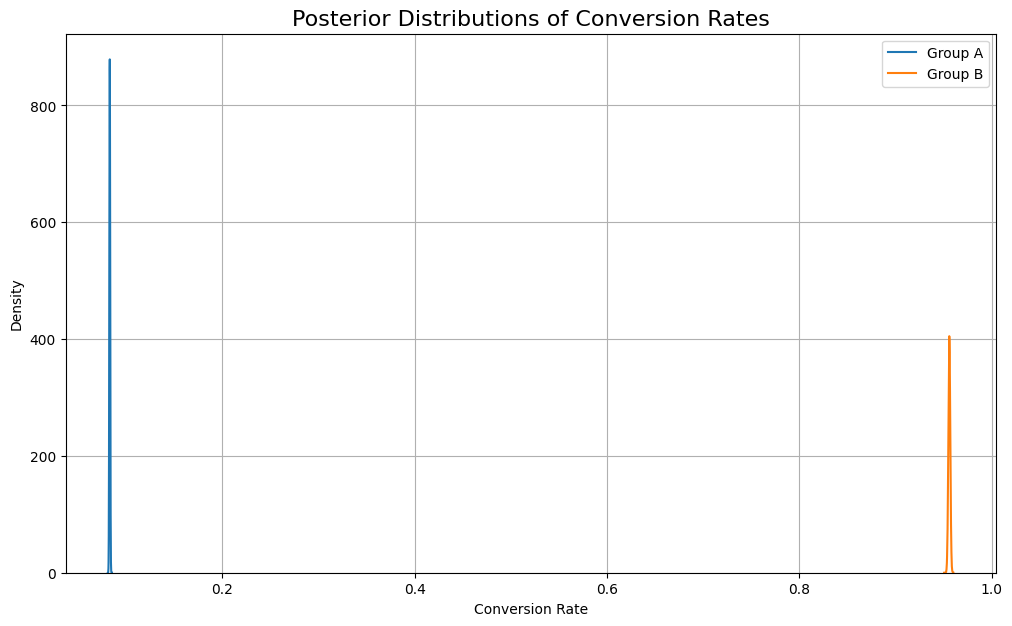



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Check Owner CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,8339,385312,2.16%
1,B,2240,42586,5.26%




✅ Z-test (2 groups)
- Z statistic: -39.0405
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 1522.8795
- p-value: 0.0000



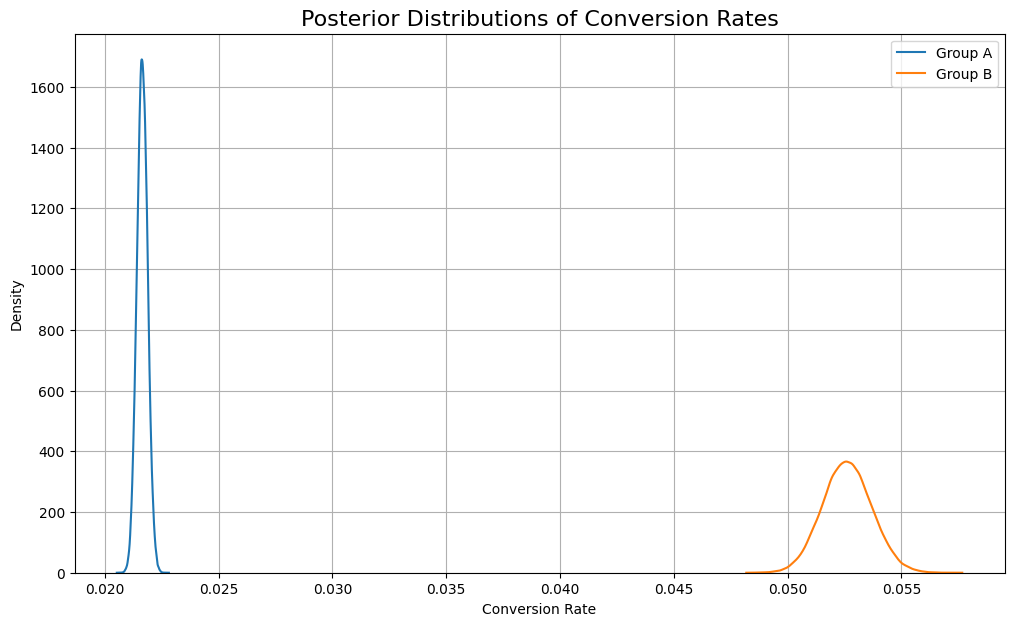



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Try MyGarage CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,7152,385312,1.86%
1,B,1711,42586,4.02%




✅ Z-test (2 groups)
- Z statistic: -29.7213
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 882.2930
- p-value: 0.0000



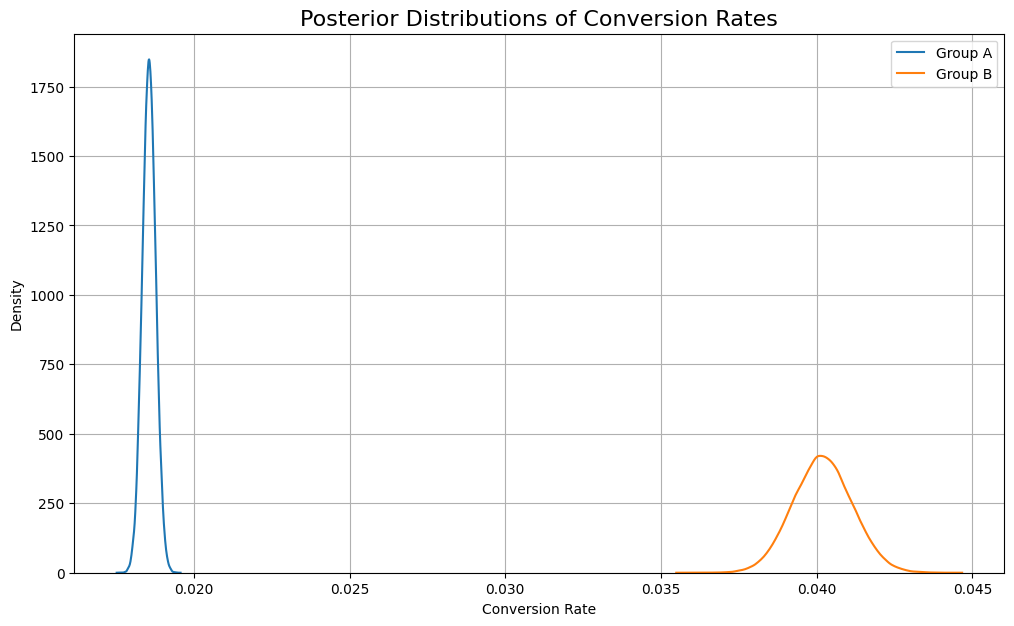



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to MyCar Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6582,385312,1.71%
1,B,1535,42586,3.60%




✅ Z-test (2 groups)
- Z statistic: -27.2204
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 739.9335
- p-value: 0.0000



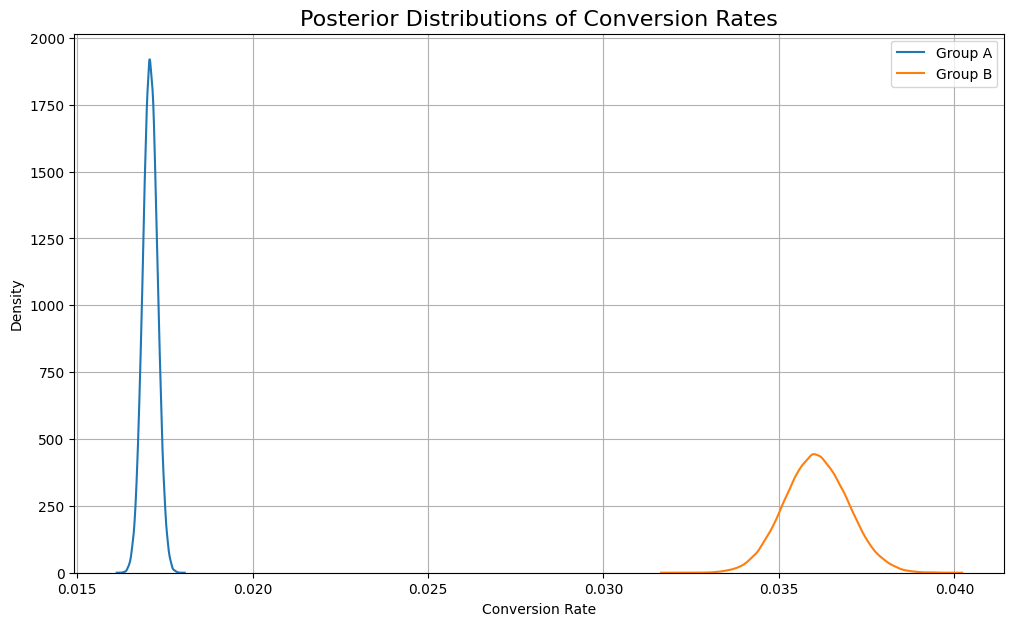



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000




######################################################################
📊 Total PCID to Estimate Complete CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,631,385312,0.16%
1,B,71,42586,0.17%




✅ Z-test (2 groups)
- Z statistic: -0.1431
- p-value: 0.8862


✅ Chi-square Test (2x2)
- Chi2 statistic: 0.0064
- p-value: 0.9362



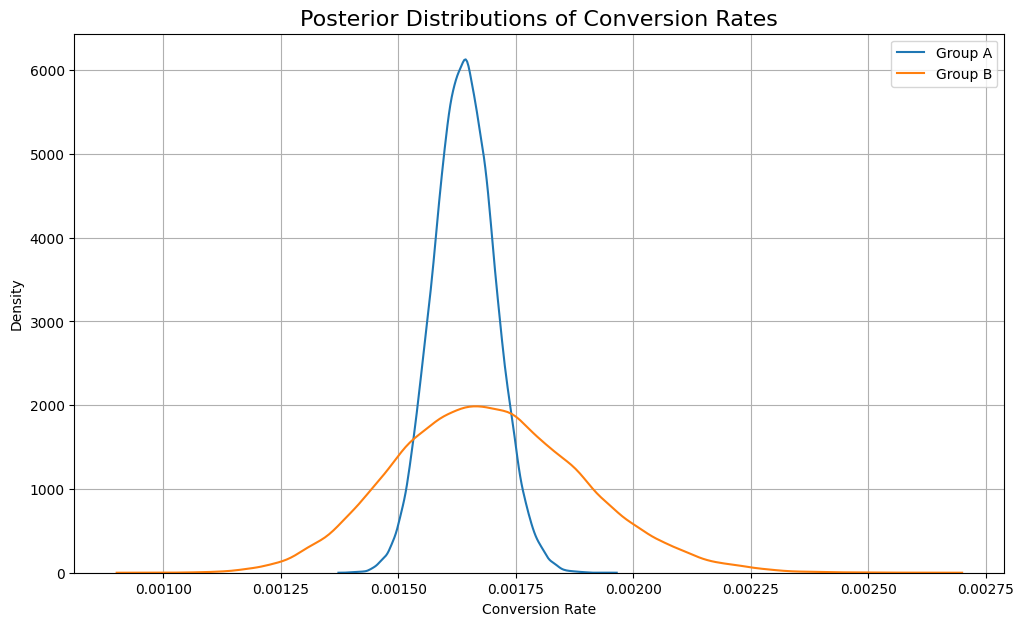



✅ Bayesian: Probability that each group is best
Probability that A is the best: 41.75%
Probability that B is the best: 58.25%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.4175,0.5825




######################################################################
📊 Total PCID to Buy Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,309623,385312,80.36%
1,B,32054,42586,75.27%




✅ Z-test (2 groups)
- Z statistic: 24.8374
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 616.5796
- p-value: 0.0000



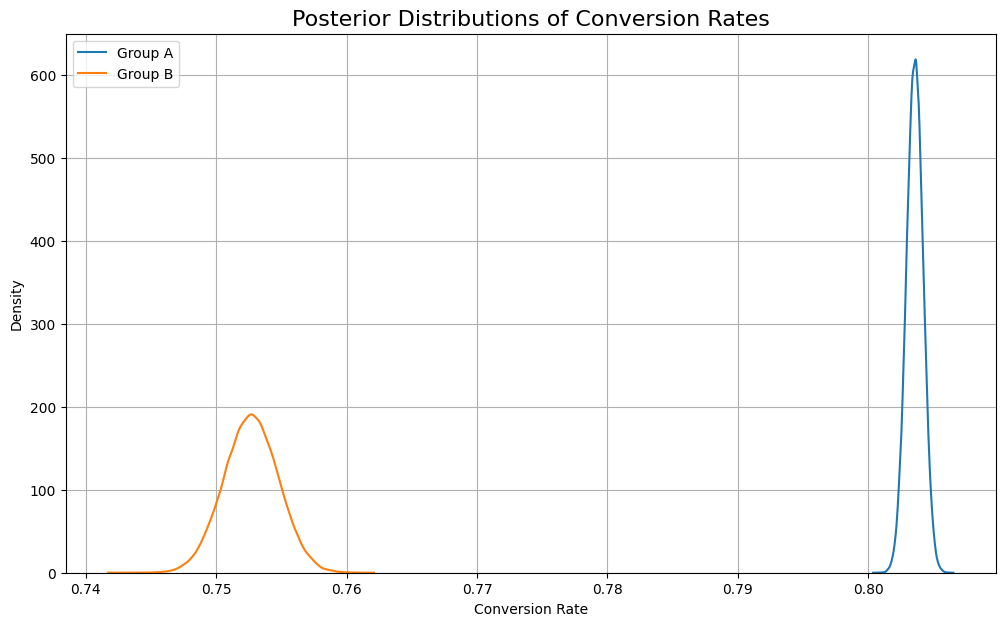



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Search Home CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,336439,385312,87.32%
1,B,35679,42586,83.78%




✅ Z-test (2 groups)
- Z statistic: 20.5595
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 422.3804
- p-value: 0.0000



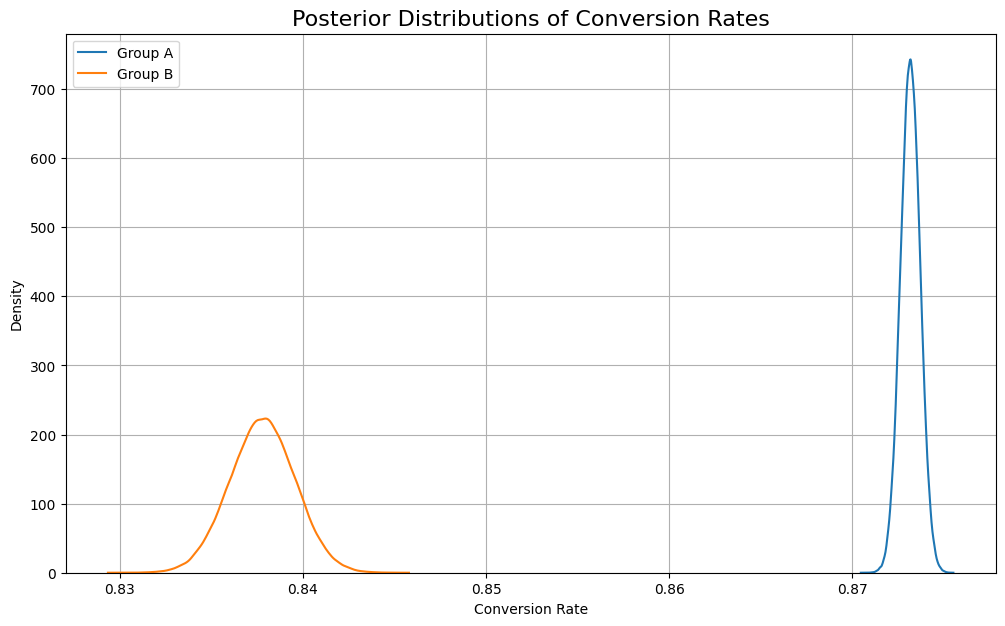



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Car Detail CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,283457,385312,73.57%
1,B,30606,42586,71.87%




✅ Z-test (2 groups)
- Z statistic: 7.5200
- p-value: 0.0000


✅ Chi-square Test (2x2)
- Chi2 statistic: 56.4633
- p-value: 0.0000



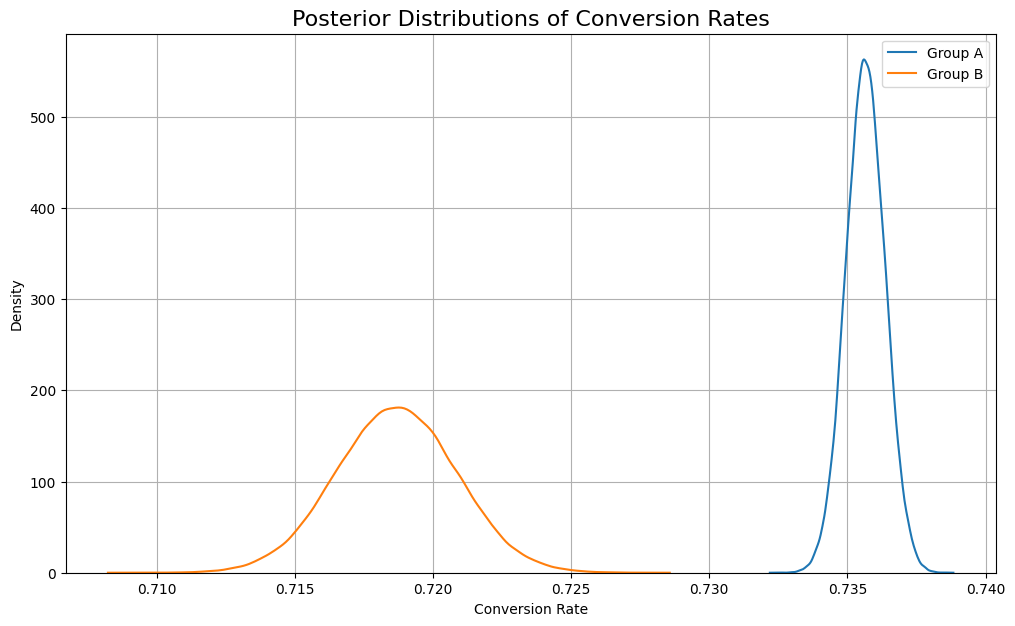



✅ Bayesian: Probability that each group is best
Probability that A is the best: 100.00%
Probability that B is the best: 0.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000




######################################################################
📊 Total PCID to Contact Click CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,6711,385312,1.74%
1,B,725,42586,1.70%




✅ Z-test (2 groups)
- Z statistic: 0.5885
- p-value: 0.5562


✅ Chi-square Test (2x2)
- Chi2 statistic: 0.3237
- p-value: 0.5694



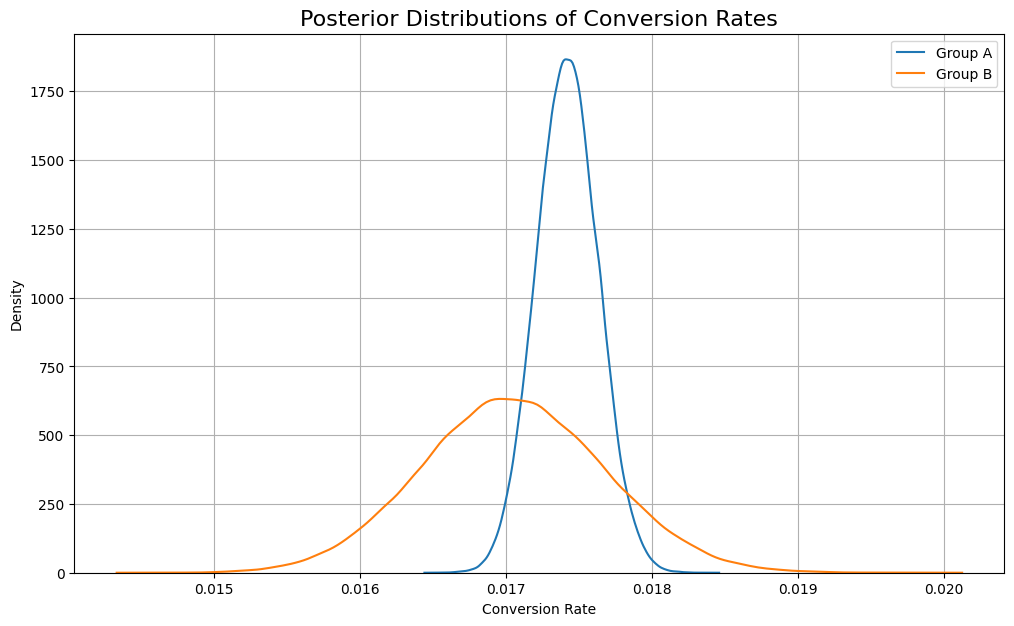



✅ Bayesian: Probability that each group is best
Probability that A is the best: 71.48%
Probability that B is the best: 28.52%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.7148,0.2852


In [ ]:
# 그룹, 모수, 지표들을 df에서 바로 가져오기
groups = df['abtest_group'].tolist()
trials = df['total_pcid'].values

# 분석할 지표 목록 (df 컬럼명 기준)
metric_columns = [
    "sell_home",
    "check_owner",
    "try_mygarage",
    "mycar_home_ing",
    "estimate_complete",
    "buy_home",
    "search_home",
    "car_detail",
    "car_detail_contact"
]

# 각 지표에 대한 label 지정 (원하는 이름으로 바꿔도 됩니다)
metric_labels = {
    "sell_home": "Total PCID to Sell Home CVR",
    "check_owner": "Total PCID to Check Owner CVR",
    "try_mygarage": "Total PCID to Try MyGarage CVR",
    "mycar_home_ing": "Total PCID to MyCar Home CVR",
    "estimate_complete": "Total PCID to Estimate Complete CVR",
    "buy_home": "Total PCID to Buy Home CVR",
    "search_home": "Total PCID to Search Home CVR",
    "car_detail": "Total PCID to Car Detail CVR",
    "car_detail_contact": "Total PCID to Contact Click CVR"
}

# 전체 지표 루프 실행
for col in metric_columns:
    successes = df[col].values
    abtest_auto(groups, successes, trials, metric_name=metric_labels[col])